<a href="https://colab.research.google.com/github/kyochanpy/Google_Smartphone_Decimeter_Challenge/blob/main/filter/pfilter_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import numpy.random as rd
import pandas as pd

import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
exsample_df = pd.read_csv("http://daweb.ism.ac.jp/yosoku/materials/PF-example-data.txt")

In [86]:
exsample_df

,-0.462713
0,-0.417415
1,0.539800
2,0.209401
3,-0.331078
4,0.018611
...,...
94,1.323630
95,0.241479
96,0.470188
97,0.888042


In [139]:
train = pd.read_csv('/content/drive/MyDrive/GSDC/baseline_locations_train.csv')

In [140]:
train.head()

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423579,-122.094114,-34.49,2020-05-14-US-MTV-1_Pixel4


In [178]:
train['latDeg'].describe()

count    131342.000000
mean         37.435206
std           0.082712
min          37.321683
25%          37.371575
50%          37.424360
75%          37.469109
max          37.690836
Name: latDeg, dtype: float64

Text(0.5, 1.0, 'Train latDeg Data')

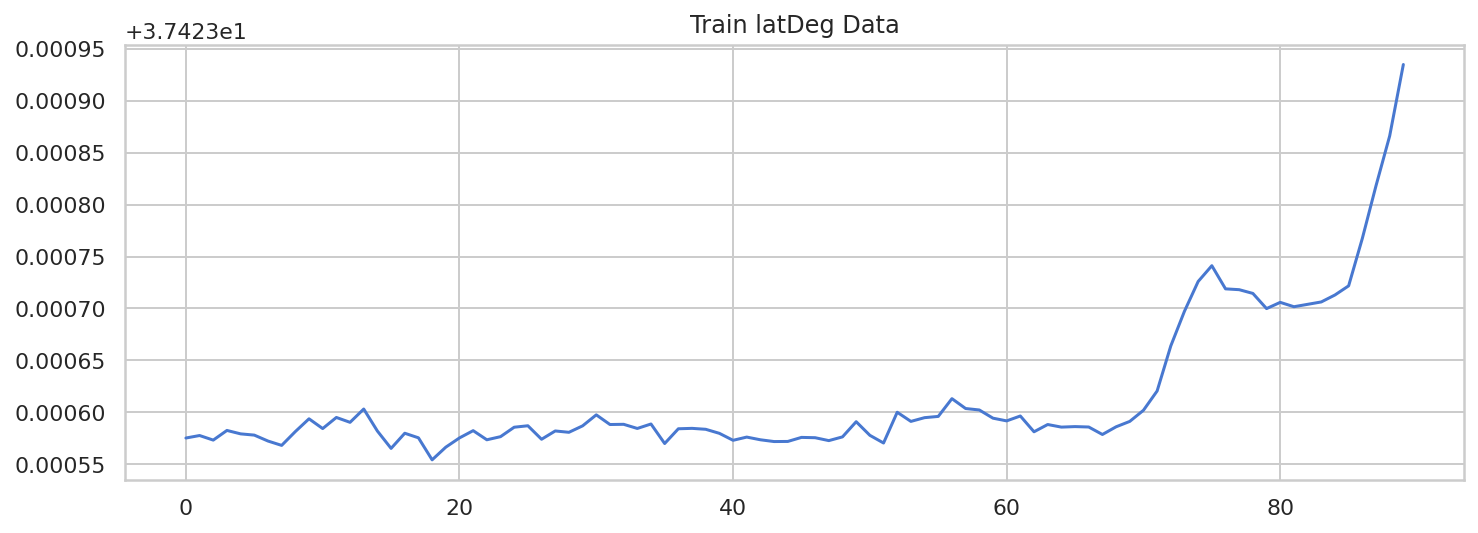

In [141]:
train['latDeg'].head(90).plot(figsize=(12,4))
plt.title("Train latDeg Data")

In [142]:
#検証データとしてtrain.head(90)のデータを用いる。
df = train['latDeg'].head(90)

Text(0.5, 1.0, 'Train latDeg Data')

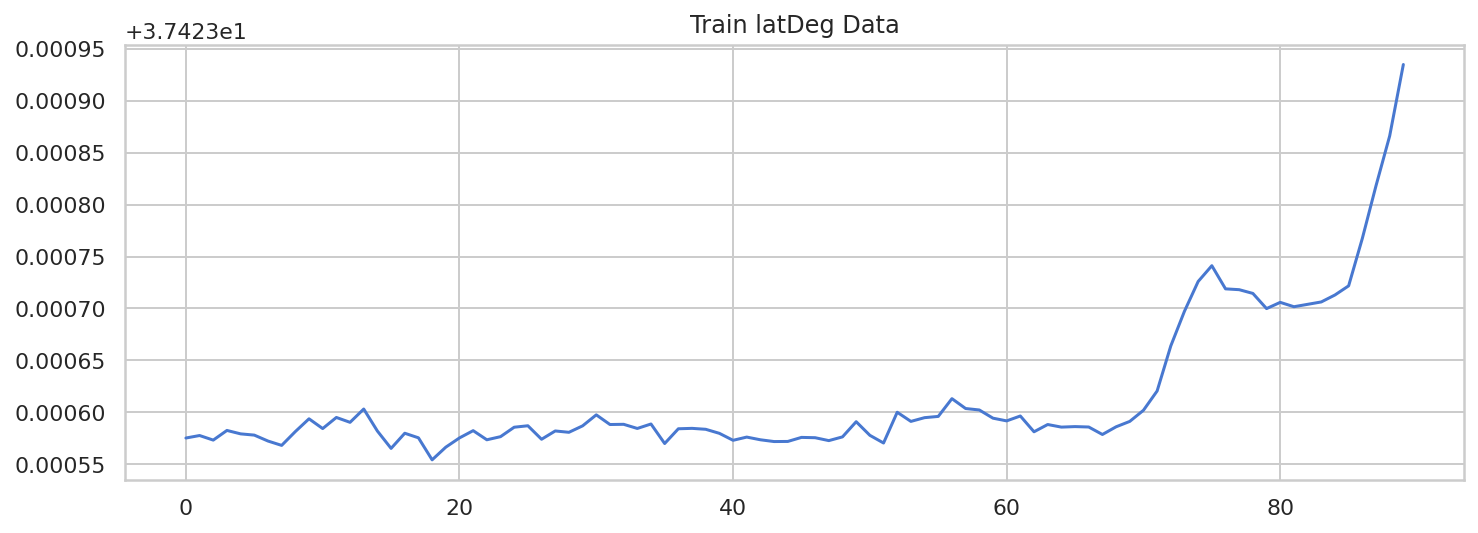

In [143]:
df.plot(figsize=(12,4))
plt.title("Train latDeg Data")

In [204]:
class ParticleFilter(object):
    def __init__(self, y, n_particle, sigma_2, alpha_2):
        self.y = y
        self.n_particle = n_particle
        self.sigma_2 = sigma_2
        self.alpha_2 = alpha_2
        self.log_likelihood = -np.inf
    
    def norm_likelihood(self, y, x, s2):
        return (np.sqrt(2*np.pi*s2))**(-1) * np.exp(-(y-x)**2/(2*s2))

    def F_inv(self, w_cumsum, idx, u):
            if np.any(w_cumsum < u) == False:
                return 0
            k = np.max(idx[w_cumsum < u])
            return k+1
        
    def resampling(self, weights):
        w_cumsum = np.cumsum(weights)
        idx = np.asanyarray(range(self.n_particle))
        k_list = np.zeros(self.n_particle, dtype=np.int32) # サンプリングしたkのリスト格納場所
        
        # 一様分布から重みに応じてリサンプリングする添え字を取得
        for i, u in enumerate(rd.uniform(0, 1, size=self.n_particle)):
            k = self.F_inv(w_cumsum, idx, u)
            k_list[i] = k
        return k_list

    def resampling2(self, weights):
        """
        計算量の少ない層化サンプリング
        """
        idx = np.asanyarray(range(self.n_particle))
        u0 = rd.uniform(0, 1/self.n_particle)
        u = [1/self.n_particle*i + u0 for i in range(self.n_particle)]
        w_cumsum = np.cumsum(weights)
        k = np.asanyarray([self.F_inv(w_cumsum, idx, val) for val in u])
        return k
    
    def simulate(self, seed=71):
        rd.seed(seed)

        # 時系列データ数
        T = len(self.y)
        
        # 潜在変数
        x = np.zeros((T+1, self.n_particle))
        x_resampled = np.zeros((T+1, self.n_particle))
        
        # 潜在変数の初期値
        initial_x = rd.normal(37.42348, 1, size=self.n_particle)
        x_resampled[0] = initial_x
        x[0] = initial_x

        # 重み
        w        = np.zeros((T, self.n_particle))
        w_normed = np.zeros((T, self.n_particle))

        l = np.zeros(T) # 時刻毎の尤度

        for t in range(T):
            print("\r calculating... t={}".format(t), end="")
            for i in range(self.n_particle):
                # 1階差分トレンドを適用
                v = rd.normal(0, np.sqrt(self.alpha_2*self.sigma_2)) # System Noise
                x[t+1, i] = x_resampled[t, i] + v # システムノイズの付加
                w[t, i] = self.norm_likelihood(self.y[t], x[t+1, i], self.sigma_2) # y[t]に対する各粒子の尤度
            w_normed[t] = w[t]/np.sum(w[t]) # 規格化
            l[t] = np.log(np.sum(w[t])) # 各時刻対数尤度

            # Resampling
            #k = self.resampling(w_normed[t]) # リサンプルで取得した粒子の添字
            k = self.resampling2(w_normed[t]) # リサンプルで取得した粒子の添字（層化サンプリング）
            x_resampled[t+1] = x[t+1, k]
            
        # 全体の対数尤度
        self.log_likelihood = np.sum(l) - T*np.log(n_particle)
        
        self.x = x
        self.x_resampled = x_resampled
        self.w = w
        self.w_normed = w_normed
        self.l = l
        
    def get_filtered_value(self):
        """
        尤度の重みで加重平均した値でフィルタリングされ値を算出
        """
        return np.diag(np.dot(self.w_normed, self.x[1:].T))
        
    def draw_graph(self):
        # グラフ描画
        T = len(self.y)
        
        plt.figure(figsize=(16,8))
        plt.plot(range(T), self.y)
        plt.plot(self.get_filtered_value(), "g")
        
        for t in range(T):
            plt.scatter(np.ones(self.n_particle)*t, self.x[t], color="r", s=2, alpha=0.1)
        
        plt.title("sigma^2={0}, alpha^2={1}, log likelihood={2:.3f}".format(self.sigma_2, 
                                                                                 self.alpha_2, 
                                                                                 self.log_likelihood))
        plt.ylim(37.42355,37.42395)
        #plt.show()

In [205]:
n_particle = 10 ** 3 * 5
sigma_2 = 1e-9
alpha_2 = 1

In [206]:
pf = ParticleFilter(df.values, n_particle, sigma_2, alpha_2)

In [207]:
pf.simulate()

 calculating... t=89

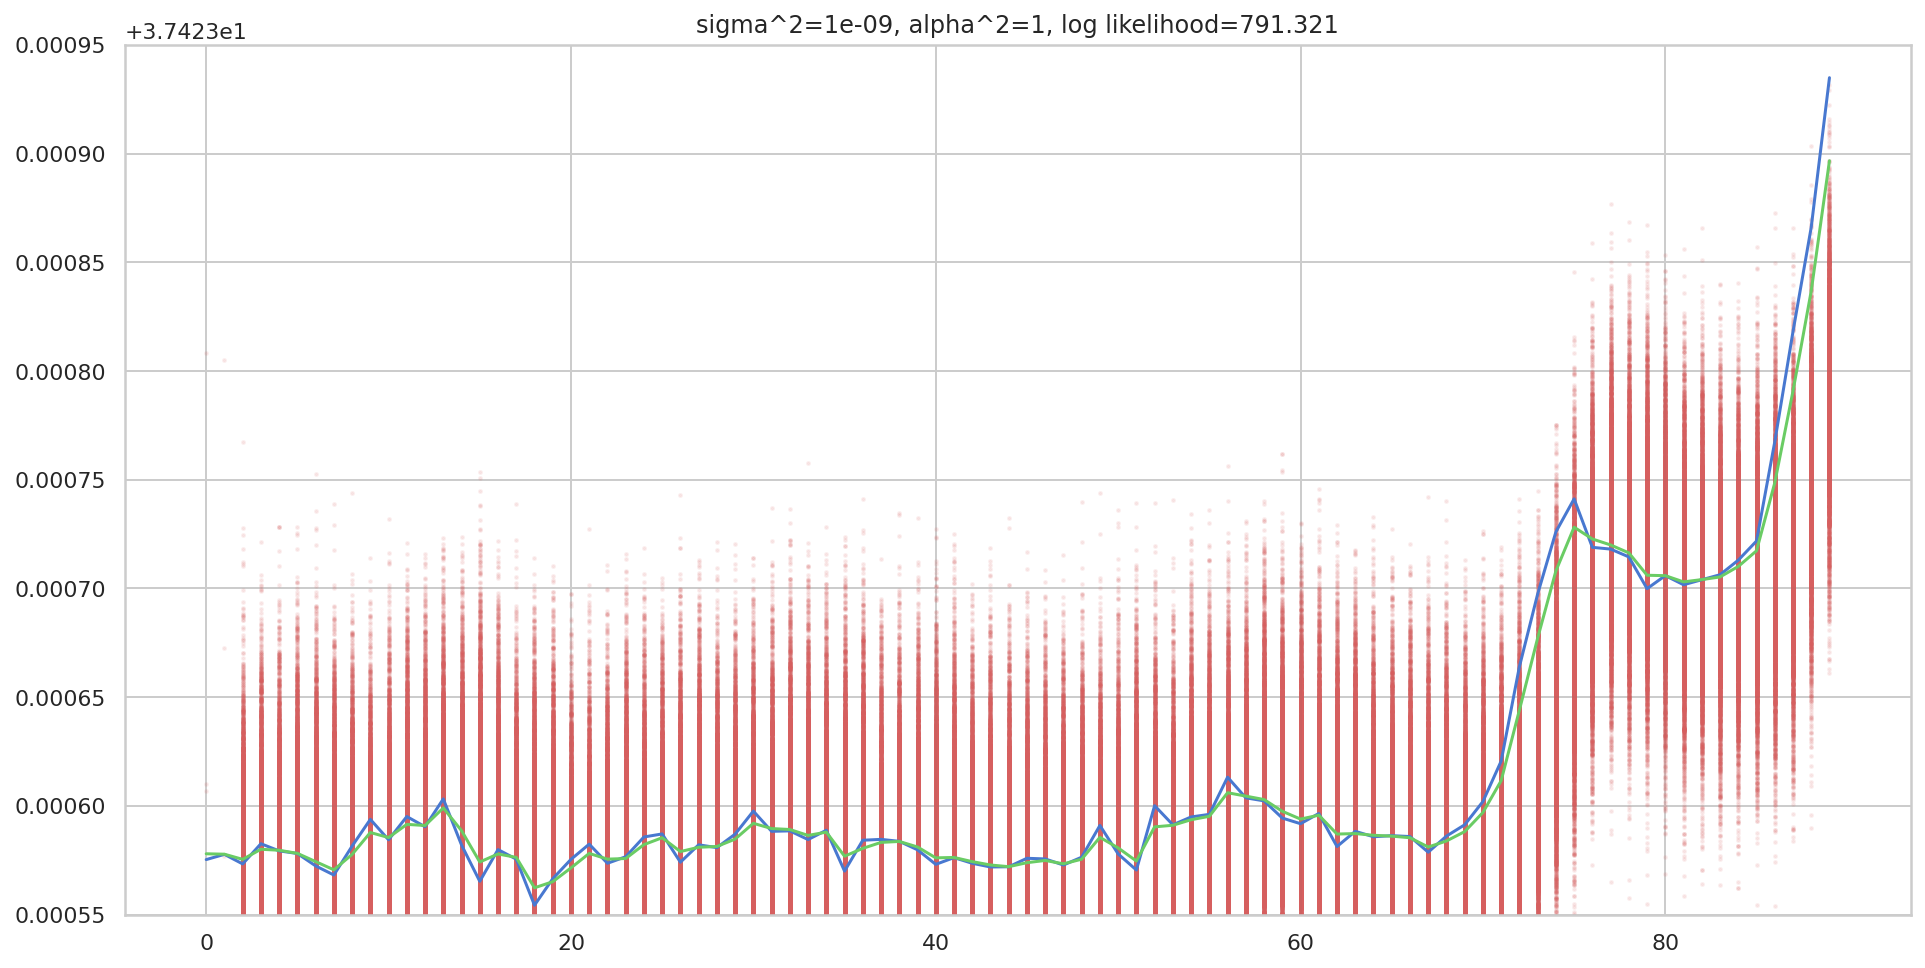

In [208]:
pf.draw_graph()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/structural.py:1661: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                   90
Model:                    local level   Log Likelihood                 836.250
Date:                Sun, 30 May 2021   AIC                          -1668.501
Time:                        10:23:54   BIC                          -1663.524
Sample:                             0   HQIC                         -1666.495
                                 - 90                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.689e-10   7.43e-10      0.227      0.820   -1.29e-09    1.62e-09
sigma2.level      3.865e-10   8.64e-10      0.447      0.655   -1.31e-09    2.08e-09
Ljung-Box (Q):              

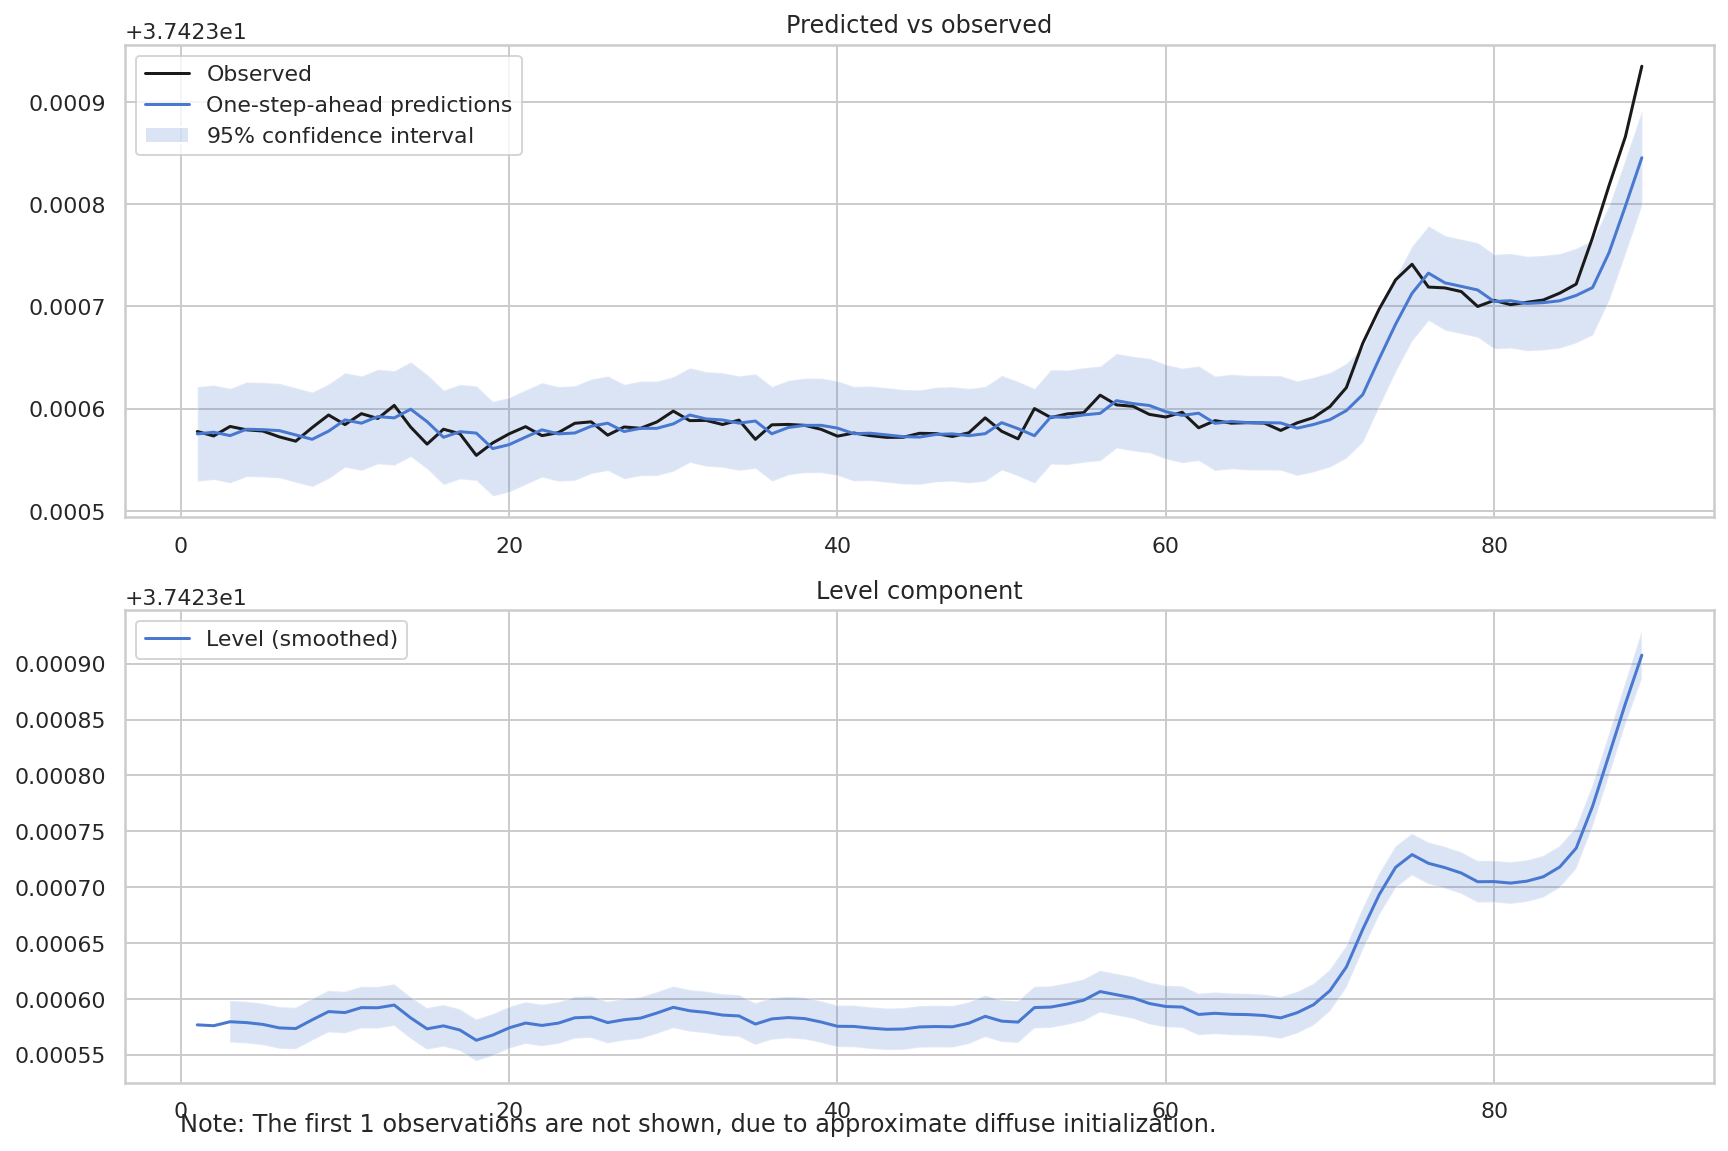

In [209]:
import statsmodels.api as sm

# Fit a local level model
mod_ll = sm.tsa.UnobservedComponents(df.values, 'local level')
res_ll = mod_ll.fit()

print(res_ll.summary())

# Show a plot of the estimated level and trend component series
fig_ll = res_ll.plot_components(legend_loc="upper left", figsize=(12,8))
plt.tight_layout()